## 第三部分 二维码识别

第二部分中，已经从车票中已经截取出了较为端正且占据图片最主要部分的二维码图片。但是直接使用zbar库识别只能识别出38张，效果很不理想。因此采用一些方法进行增强。

观察未能识别出的二维码，可以观察到它们有明显的几处共同点：
* 背景与前景相差较小
* 二维码中部分像素较模糊
* 二维码附近有少量污染
* 二维码三个定位块比例不一致
* ……

为了解决以上主要问题，主要采取的方法有：
* 二维码增强
* 二维码变形

最终运用算法，在训练集上一共识别出79/100张火车票二维码。

In [1]:
# temp import
import os
import cv2
import numpy as np
from tqdm import tqdm
from pyzbar import pyzbar
import matplotlib.pyplot as plt

### 二维码增强
此处用一张无法直接扫出的图：```0002.bmp```为例说明二维码的增强算法，包括这张图在内的18张图最终通过增强算法识别出来：

result: []


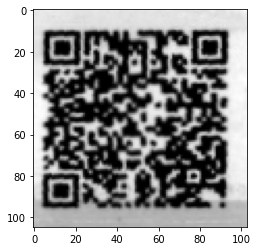

In [2]:
img2 = cv2.imread('qr/0002.bmp', cv2.IMREAD_GRAYSCALE)

print('result:',pyzbar.decode(img2)) # no result
plt.imshow(img2, cmap='gray')

#### 顶帽变换

对于这张图片，即便是微信的强大二维码识别器也没能通过拍照扫描出来，但是如果直接讲这张图保存为文件并使用微信扫描，其用了**明显比扫描一般二维码更长的时间**扫描出了二维码的内容。

这张图片的特点是：内部像素分界线较模糊，且下方背景在颜色上有所区别。

为了避免背景上的差异，这里使用了顶帽变换：$T_{hat}(f)=f-(f\circ b)$.

但需要注意，顶帽变换是删除暗背景上的亮物体后，再被原图像所进去达到消除背景的目的。这里更加白而亮的是背景，而较暗较黑的二维码才是目标，因此需要在顶帽变换的前后将图像取反，顶帽变换后的结果如下图所示：

result: []


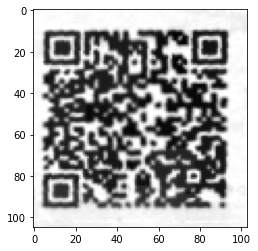

In [3]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

img = 255 - img2
morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
output = 255 - cv2.subtract(img, morphed)

print('result:',pyzbar.decode(output)) # no result
plt.imshow(output, cmap='gray')

#### 高通滤波
可以看到，顶帽变化后背景色的差异被明显消除，且背景更加白，与二维码本身的差异更加，直观上图像的对比度增强。与原先的图片相比顶帽变换取得了很好的效果。即便如此，pyzbar依然未能将这张图识别出来，从图像看推测是因为部分像素有些模糊，为此考虑增加一个高通滤波。

经过一番尝试（见最后），最终依然选取了最简单的拉普拉斯算子作增强，增强后的图片如下：

result []


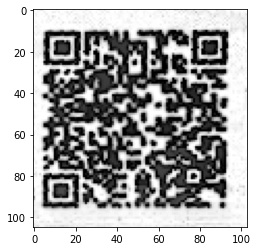

In [4]:
laplacian = cv2.Laplacian(output, -1)
new_img =cv2.subtract(output, laplacian).astype(np.uint8)
print('result', pyzbar.decode(new_img))
plt.imshow(new_img, cmap='gray')

#### 二值化（自适应&全局）
经过拉普拉斯增强后，二维码中各像素的轮廓变得清晰，而且此时微信在拍照模式识别二维码时，也可以将其识别出来。这说明尽管目前pyzbar依然未能识别出二维码，先前的方法已经使得二维码更加容易识别。但目前为止库未能识别出二维码，推测是较多的灰度种类对识别造成的一定的影响，因此将其二值化。

尽管顶帽变换已经将背景清理得较为干净，但仍然不能保证顶帽变换一定可以取得完美的结果，因此使用局部的二值化是有必要的。这里首先使用一种局部二值化方法——自适应二值化。

result: [Decoded(data=b'200087091412511530034667018715167684507415962791635763805933362167467427339290781150856974557013246690526991430482730086132393961481603217718497', type='QRCODE', rect=Rect(left=5, top=10, width=87, height=85), polygon=[Point(x=5, y=95), Point(x=92, y=95), Point(x=92, y=10), Point(x=6, y=10)])]


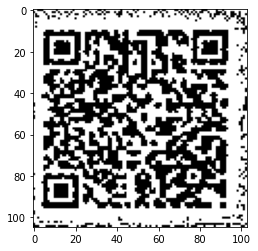

In [5]:
test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
print('result:', pyzbar.decode(test))
plt.imshow(test, cmap='gray')

#### 汇总
自适应二值化后，得到的二维码已经能被成功识别出来。为了避免自适应滤波失败的情况，如果自适应滤波失败将在之后枚举二值化的threshold，尝试识别，知道扫出或全部枚举完成为止。将以上操作合并，即构成二维码的增强过程，下图显示各过程中图像的变化：

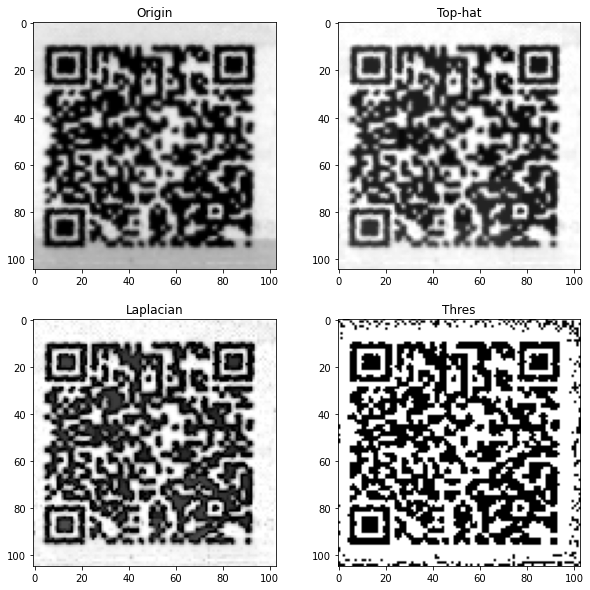

In [6]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Origin')
plt.imshow(img2, cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Top-hat')
plt.imshow(output, cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Laplacian')
plt.imshow(new_img, cmap='gray')
plt.subplot(2, 2, 4)
plt.title('Thres')
plt.imshow(test, cmap='gray')

以下是二维码增强过程的代码，即汇总后的操作：

In [4]:
def recog_qr(img, not_continue=False):
    barcodes=pyzbar.decode(img)
    if len(barcodes) > 0:
        return 0, barcodes[0].data.decode('utf-8')
    
    img = 255 - img
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    output = 255 - cv2.subtract(img, morphed)
    barcodes=pyzbar.decode(output)
    if len(barcodes) > 0:
        return 1, barcodes[0].data.decode('utf-8')

    laplacian = cv2.Laplacian(output, -1)
    new_img =cv2.subtract(output, laplacian)
    barcodes=pyzbar.decode(new_img)
    if len(barcodes) > 0:
        return 2, barcodes[0].data.decode('utf-8')
    
    test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 3, barcodes[0].data.decode('utf-8')
    test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 3, barcodes[0].data.decode('utf-8')
    
    if not_continue:
        return -1, ''

    for i in range(127, 256):  #粗暴的阈值处理
        _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
        barcodes=pyzbar.decode(output2)
        if len(barcodes) != 0:
            return 4, barcodes[0].data.decode('utf-8')
    return -1, ''

直接利用此增强函数，可额外识别出18张二维码，最终的统计结果表明，其中的每一步都使得额外识别出的二维码增多。具体可见稍后的完整统计数据。可以在下方修改图片文件名观察结果：

result: (3, '160573880588446653888586080716060867939114590463043555344813116325236144205644088570421821162053177899242722637700191793898215102901936272194193')


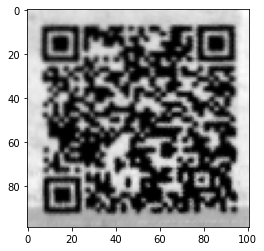

In [5]:
img = cv2.imread('qr/0009.bmp', cv2.IMREAD_GRAYSCALE)
print('result:', recog_qr(img))
plt.imshow(img, cmap='gray')

### 二维码变形
在做完以上操作后，分析未识别出的二维码，发现其中有一大部分二维码，它们的三个定位块左侧和右侧的大小不一，而即便是（看上去）清晰的二维码，使用微信等很成熟的二维码识别软件也未能识别出，下图的两个图片即是典型的对比，其中左侧二维码可以识别，但右侧的二维码无法识别：

left:	 (0, '020857431064020019372589033206091774738561342081499839159125585322699570616599910102789788168182714050628291939914057657074397649366418084317787')
right:	 (-1, '')


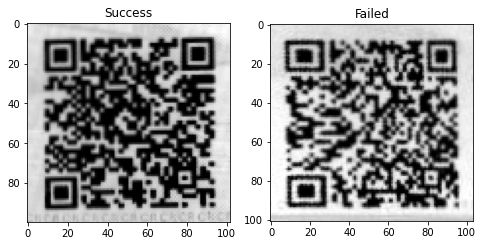

In [6]:
img = cv2.imread('qr/0004.bmp', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('qr/0003.bmp', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Success')
plt.imshow(img2, cmap='gray')
print('left:\t', recog_qr(img2))

plt.subplot(1, 2, 2)
plt.title('Failed')
plt.imshow(img, cmap='gray')
print('right:\t', recog_qr(img))

上方右图中，很明显地观察到左侧两个定位块并行比右侧的定位块要“胖”，有可能是自动打印车票时车票移动速度不均匀导致的。因此考虑如下简易模型：二维码水平线```divide```（比例）处往左，图像需要在水平方向缩放```rate```倍后，使得左边部分不协调的比例相对于右边更加正常，假设$divide=0.4,~rate=0.8$，纠正出的如下代码所示：


result	 (0, '030755010316505862241125261889992389638269950028739393303410107418124646925447071471998936107042924718513843814341408380917162804569442148109605')


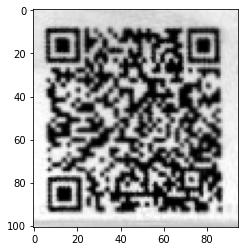

In [7]:
r, c = img.shape
rate = 0.8
divide = 0.4

crop_x = int(c * divide)
left_img = img[:, :crop_x]
right_img = img[:, crop_x:]

rl, cl = left_img.shape
left_img2 = cv2.resize(left_img, (int(cl*rate),  rl))
fit_img = np.hstack([left_img2, right_img])
print('result\t', recog_qr(fit_img))
plt.imshow(fit_img, cmap='gray')

原来的图经过这种部分缩放的处理后，由原本的不可识别变为可识别。由于数据集中这样图由很多，因此可采用的方法是：先尝试直接调用二维码增强函数识别，如果无法识别，则尝试在合理的区间与步长内枚举上述```divide```与```rate```，再次尝试识别，直到识别出为止。另外考虑到效率问题，在枚举变换参数时二维码增强不再进行最后一步枚举二值化阈值，根据实验其性能极其有限而且耗时巨大。

经过此方法，又可额外识别出23张二维码，函数如下：

In [8]:
def process_qr(img):
    status, content = recog_qr(img, False)
    if status != -1:
        return status, content
    
    for rate in np.arange(0.8, 1, 0.01):
        for divide in np.arange(0.25, 0.5, 0.05):
            r, c = img.shape
            crop_x = int(c * divide)
            left_img = img[:, :crop_x]
            right_img = img[:, crop_x:]
            rl, cl = left_img.shape
            left_img2 = cv2.resize(left_img, (int(cl*rate),  rl))
            fit_img = np.hstack([left_img2, right_img])

            status, content = recog_qr(fit_img, True)
            if status != -1:
                return status, content
    return -1, ''

将以上操作汇总，即得到最终的处理函数。在所有二维码上进行识别，观察其结果，最终得到79/100的识别率，是一个较理想的水平：

In [12]:
def recg_all_qrcodes(qr_dir, result_file):
    counter = [0, 0, 0, 0, 0]

    results = {}
    for file_name in tqdm(os.listdir(qr_dir)):
        try:
            img = cv2.imread(os.path.join(qr_dir, file_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            status, result = process_qr(img)
            results[file_name] = result
            if status != -1:
                counter[status] += 1
        except Exception as e:
            print("\nFail at {}: {}, skipped".format(file_name, e.args[0]))
        
    
    pairs = sorted(results.items(), key=lambda x: x[0])
    with open(result_file, 'w') as f:
        for n, r in pairs:
            f.write('{} {}\n'.format(n, r))

    total = sum(counter)
    print()
    print('Sum*', 'Base', 'T-hat', 'lapla', 'athrs', 'thrs', sep='\t')
    print(total, *counter, sep='\t')
    print('Results were saved to {}.'.format(result_file))
    return results

In [13]:
results = recg_all_qrcodes('qr', 'predictions.txt')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]
Sum*	Base	T-hat	lapla	athrs	thrs
79	46	5	14	13	1
Results were saved to predictions.txt.



上面的输出结果表明：一共识别出了79个二维码，其中无需任何增强算法的有46个，使用顶帽变换后得出结果的有5个，使用拉普拉斯算子增强后识别出的共14个，在自适应二值化后识别出的共13个，最终枚举二值化阈值阶段识别出的有1个。

### 未采用的尝试
事实上，二维码增强识别过程尝试过非常多的方法，但大多数对于识别率的提升没有明显帮助，此处列出一个有代表性的尝试。

经过观察，发现7号图片的二维码较清晰，而且微信可以识别出，但此处pyzbar最终未能识别出来，实验过程中尝试过在频域使用巴斯沃斯高通滤波器进行处理，如下：

[]


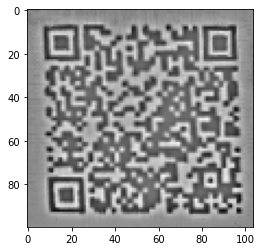

In [19]:
img = cv2.imread('qr/0007.bmp', cv2.IMREAD_GRAYSCALE)

D = np.zeros((201, 201))
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D[i, j] = np.sqrt((i-100)**2+(j-100)**2)
D[100, 100]=1e-3

fft_img = np.fft.fft2(img)
r, c = img.shape
fft_img = np.fft.fftshift(fft_img)

fft_img = np.fft.fft2(img)
r, c = img.shape
fft_img = np.fft.fftshift(fft_img)

D0, n = 10, 5
trunc_D = D[100-r//2:100-r//2+r, 100-c//2:100-c//2+c]
H = 1 / (1 + (D0/trunc_D)**2)
H[r//2, c//2]=1

filtered_img = H * fft_img
filtered_img = np.fft.ifft2(filtered_img)
filtered_img = np.abs(filtered_img)

filtered_img = np.around(np.abs(filtered_img)).astype(np.uint8)

barcodes=pyzbar.decode(filtered_img)
print(barcodes)
plt.imshow(filtered_img, cmap='gray')

经过高通滤波后，即便是拍照识别，微信也能**轻松而快速**地识别出来。此处未能识别出的原因很可能是因为背景有灰度而前景二维码眼色偏浅对比度较小。但是，此处尝试了各种二值化以及提高图像对比度的方法，都未能成功使得pyzbar库识别出它。此方法曾经加入过识别二维码的过程中，但发现这对正确率的提升没有任何帮助，因此最终没有采用频域滤波。考虑到微信可以很轻松地识别出，因此针对这张图的优化是一个可以深入的课题。

## 实验结果与分析
本次实验讲原本的火车票图片，依次经过票面检测、二维码提取、二维码增强与变形三个阶段以识别票面上的二维码，在训练集上取得79%的识别率，通过二维码增强与变形算法，其中有41张未能直接识别出的二维码最终被识别出，算法有可观的效果。纵观整个过程的结果，总体而言经由图像处理的算法后得到的图片效果较好，详见输出目录，但依然有部分二维码存在提取效果不佳的情况，如下图：

0038.bmp ---
0027.bmp 030548451152246418680229581831360524204197254825489705178177152107542699417202081071549758947093168365115170750111890804955233001833600269376908
0083.bmp 030754921250498794954939437990380824216024149588093384338399522004309837132738033311338684946207874147841990623452586356336376881432103194221134


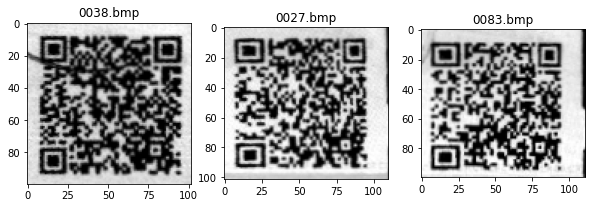

In [16]:
file_list = '0038.bmp', '0027.bmp', '0083.bmp'
img_list = map(lambda x: cv2.imread(os.path.join('qr', x), cv2.IMREAD_GRAYSCALE), file_list)
img_list = list(img_list)

plt.figure(figsize=(10, 5))
for i in range(3):
    res = results[file_list[i]]
    print(file_list[i], res if len(res) > 0 else '---')
    plt.subplot(1 ,3, i + 1)
    plt.title(file_list[i])
    plt.imshow(img_list[i], cmap='gray')

以上是处理效果没有达到最好的图，这在每个阶段都有所原因。其中38号图在旁边有污染的情况下，也将旁边的一部分识别了进来，同时在二维码的识别与增强阶段没有过多处理旁边有污染的情形（事实上在二维码识别阶段尝试过无法识别时进行crop_center操作，但是对于38号图无论裁剪多大还是无法进行识别）。

而27号图与83号图，由于第一阶段残留了部分黑色边缘而在第二阶段时做形态学处理时，将黑色的边框与二维码粘连在了一起，使得实际提取出的区域稍大。不过这两张图的二维码在第三阶段均被成功识别了出来（见```predictions.txt```），表明这对最终的结果影响不算太大。

再观察最后的二维码识别阶段，第三部分已经阐释过可被微信识别的7号二维码，因为二值化或增大对比度包括顶帽变换等方法，依然无法被pyzbar识别而最终放弃使用巴斯沃斯高通滤波器（对于其他二维码也存在前景与背景差别较小的情况）。此外还有部分二维码的本身有缺失的情况，如下图：

0011.bmp ---
0042.bmp ---
0050.bmp ---


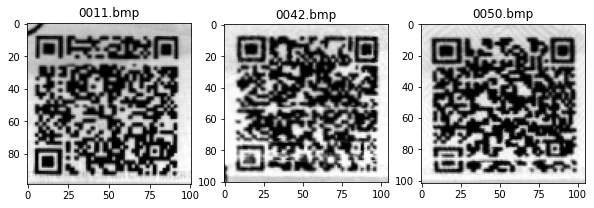

In [15]:
file_list = '0011.bmp', '0042.bmp', '0050.bmp'
img_list = map(lambda x: cv2.imread(os.path.join('qr', x), cv2.IMREAD_GRAYSCALE), file_list)
img_list = list(img_list)

plt.figure(figsize=(10, 5))
for i in range(3):
    res = results[file_list[i]]
    print(file_list[i], res if len(res) > 0 else '---')
    plt.subplot(1 ,3, i + 1)
    plt.title(file_list[i])
    plt.imshow(img_list[i], cmap='gray')

这三张二维码均未能被识别出，且这三张二维码都被一条水平直线所污染，尽管二维码有纠错机制，但无论是微信等较强的二维码识别工具还是pyzbar库，都未能成功识别。值得注意的是这三张图均在三个定位块之一附近存在污染，考虑纠错机制，如果通过算法自动将定位块补全，或许有将其识别出的可能。目前的算法未有处理此类异常现象的能力。

总之，尽管整个项目运用了许多图像处理的手段，而且算法目前有较为可观的结果，但其仍有提升的空间。

## 参考文献与资料
就用你的再加一个我们DIP的教材？

\[3\] Error Correction Feature of QR Code. https://www.qrcode.com/en/about/error_correction.html

## 附录
在第一部分使用霍夫变换检测直线并探测票面边缘。此算法在除75号图片外均能取得很好的效果，但因为75号图效果欠佳，其余图片效果类似，因此最终使用的是正文中的抽取方法而不是此处的方法。这里将代码放出，核心过程是：
* 使用霍夫变换检测票面的四条边界直线
* 计算直线的的交点得到4个顶点
* 通过透视变换摆正图像

此外，还有许多图片因为各种原因无法成功找到角点，最终未采用此算法，在在```main.py```中预留了```-a```选项，可以调用此算法。值得注意的是，此算法最终识别出了原先未能识别出的38号图片，但识别失败率很较高。如果可以考虑取并集，则训练集的识别率可以达到80%。

In [6]:
def fetch_line(lines):
    cnt = 0
    fetch_lines = np.zeros((4, 2))
    for rho, theta in lines:
        for i in range(cnt):
            if abs(rho - fetch_lines[i][0]) < 50 and abs(theta - fetch_lines[i][1]) < np.pi / 180*3:
                break
        else:
            fetch_lines[cnt][0], fetch_lines[cnt][1] = rho, theta
            cnt += 1
        if cnt == 4:
            break
    return fetch_lines
def solve_l(rho1, theta1, rho2, theta2):
    # print(rho1, theta1, rho2, theta2)
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    B2 = np.array([[np.cos(theta1), rho1],
                   [np.cos(theta2), rho2]])
    B1 = np.array([[rho1, np.sin(theta1)],
                   [rho2, np.sin(theta2)]])
    A, B1, B2 = map(lambda x: np.linalg.det(x), (A, B1, B2))
    return B1/A, B2/A

读入75号图片：

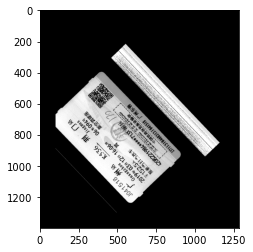

In [2]:
att_img = "train/0075.bmp"
att_img = cv2.imread(att_img, cv2.IMREAD_GRAYSCALE)
padding = 100
att_img = np.pad(att_img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))

plt.imshow(att_img, cmap='gray')

得到票面边界：

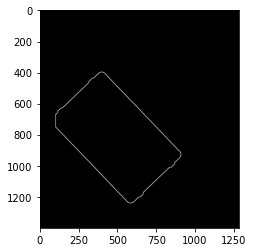

In [4]:
blurred_img = cv2.medianBlur(att_img, 5)
_, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)
canny = cv2.Canny(morphed_img, 40, 150)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp
max_contour = max_contour[::-1, :, :]

edge = np.zeros((att_img.shape[0], att_img.shape[1], 3), dtype=np.int32)
cv2.drawContours(edge, [max_contour], -1, (255, 255, 255), 2)
plt.imshow(edge, cmap='gray')


利用霍夫变换并计算直线交点，探测到4个顶点，此处用红圈表示：

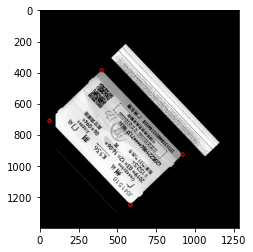

In [7]:
edge2 = cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2GRAY)
lines = cv2.HoughLines(edge2, 1, np.pi / 180, 200)
lines = lines.squeeze()
# print(lines)
fetch_lines = fetch_line(lines)
if abs(fetch_lines[0][1] - fetch_lines[1][1]) < np.pi / 180 * 25:  # 25度以内认为平行的
    fetch_lines[[1, 2], :] = fetch_lines[[2, 1], :]
elif abs(fetch_lines[2][1] - fetch_lines[1][1]) < np.pi / 180 * 25:
    fetch_lines[[0, 1], :] = fetch_lines[[1, 0], :]
# print(fetch_lines) 

points = [solve_l(*fetch_lines[i-1], *fetch_lines[i]) for i in range(4)]

pt_img = cv2.cvtColor(att_img ,cv2.COLOR_GRAY2BGR)
points = np.around(np.array(points)).astype(np.int32)

for i in range(4):
    cv2.circle(pt_img, (points[i][0], points[i][1]), 10, (255, 0, 0), 5)
plt.imshow(pt_img)

透视变换：

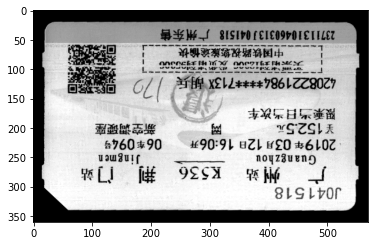

In [8]:
c = np.cross(points[1]-points[0], points[2]-points[1])
if c > 0:   # 修正为右旋标价
    points = points[::-1, :]

len1 = np.linalg.norm(points[0] - points[1])
len2 = np.linalg.norm(points[1] - points[2])
if len1 >= len2:    # 短边优先
    points = np.roll(points, 1, axis=0)

if points[0][0] > points[2][0]: # y值小的优先
    points = np.roll(points, 2, axis=0)

shape_x, shape_y = int(856 / 1.5), int(540 / 1.5) # 蓝票标准长宽比
outer_x, outer_y = 20, 20

N = np.array([[outer_x, outer_y], [outer_x, shape_y - outer_y], 
            [shape_x - outer_x, shape_y - outer_y], [shape_x - outer_x, outer_y]])
mat = cv2.getPerspectiveTransform(points.astype(np.float32), N.astype(np.float32))
output1 = cv2.warpPerspective(att_img, mat, (shape_x, shape_y))
plt.imshow(output1, cmap='gray')